<a href="https://colab.research.google.com/github/monahc1/SignNet/blob/main/asl_alphabet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kaggle API Setup**

In [31]:
# Upload kaggle.json manually
from google.colab import files
files.upload()

Saving kaggle(1).json to kaggle(1) (1).json


{'kaggle(1) (1).json': b'{"username":"monahc","key":"14aaa816ca1a24d998bccf2ee60a6b78"}'}

In [32]:
!mkdir -p ~/.kaggle
!cp "kaggle(1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

**Dataset Download & Extraction**

In [33]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip -q asl-alphabet.zip -d asl_alphabet_data
!ls asl_alphabet_data/asl_alphabet_train/

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)
replace asl_alphabet_data/asl_alphabet_test/asl_alphabet_test/A_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: asl_alphabet_train


**Import All Libraries**

In [35]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd
!pip install mediapipe --quiet
import mediapipe as mp
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Define Image Size & Paths**

In [40]:
IMG_SIZE = 64
TRAIN_DIR = "/content/asl_alphabet_data/asl_alphabet_train/asl_alphabet_train"
TEST_DIR = "/content/asl_alphabet_data/asl_alphabet_test/asl_alphabet_test"

**Raw Image Preview**

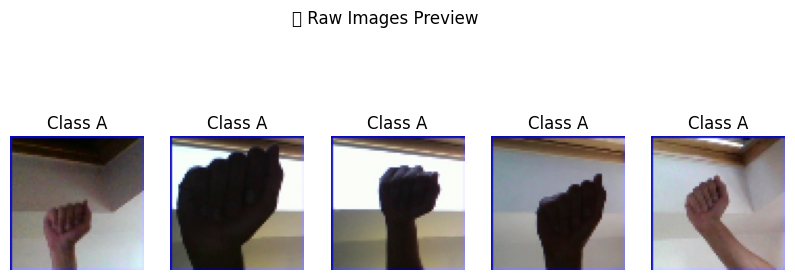

In [41]:
sample_dir = os.path.join(TRAIN_DIR, "A")
sample_imgs = [os.path.join(sample_dir, img) for img in os.listdir(sample_dir) if img.endswith(".jpg")][:5]

plt.figure(figsize=(10, 4))
for i, img_path in enumerate(sample_imgs):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Class A")
    plt.axis("off")
plt.suptitle("🟣 Raw Images Preview")
plt.show()

**CLAHE Contrast Enhancement**

In [42]:
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127898 (\N{LEVEL SLIDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


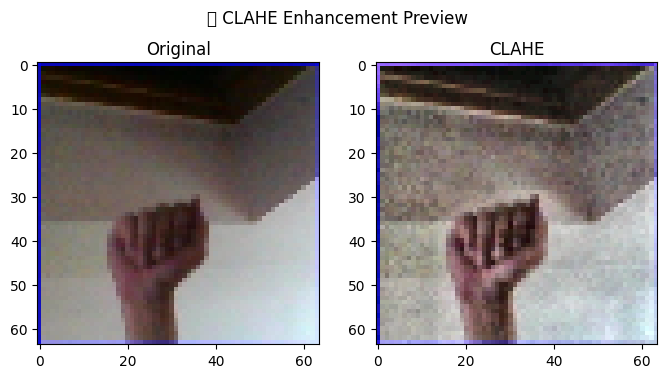

In [43]:
img_path = sample_imgs[0]
original = cv2.resize(cv2.imread(img_path), (IMG_SIZE, IMG_SIZE))
enhanced = apply_clahe(original)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
plt.title("CLAHE")
plt.suptitle("🎚 CLAHE Enhancement Preview")
plt.show()

**Data Augmentation Setup**

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='constant',


)

**Train/Validation Split with Generators**

In [46]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


**Test Set (Manual Mapping from Filenames)**

In [47]:
file_paths = []
labels = []
for filename in os.listdir(TEST_DIR):
    if filename.endswith('.jpg'):
        label = filename.split('_')[0]
        file_paths.append(os.path.join(TEST_DIR, filename))
        labels.append(label)

test_df = pd.DataFrame({
    'filename': file_paths,
    'label': labels
})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 28 validated image filenames belonging to 28 classes.


**Preview from Generator**

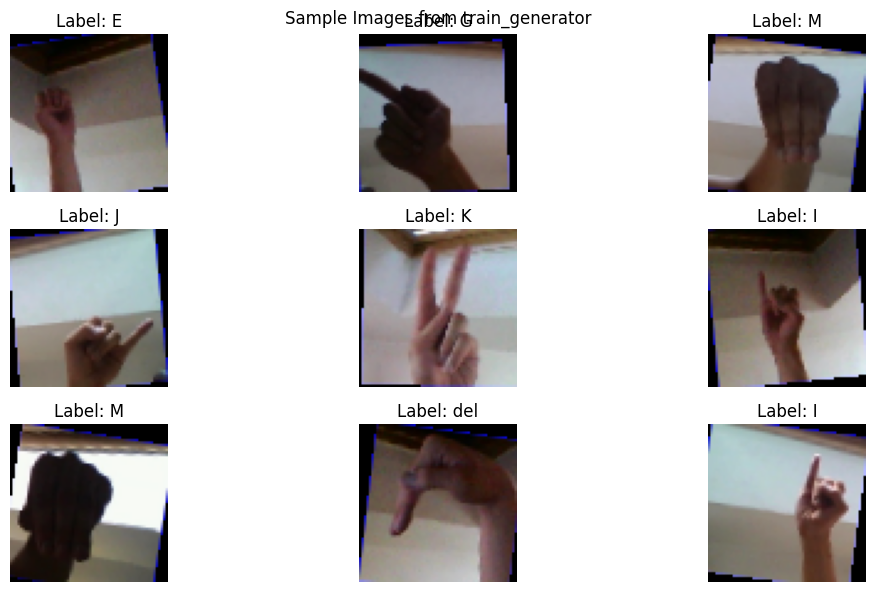

All preprocessing done — dataset ready for CNN training.


In [48]:
images, labels = next(train_generator)
label_map = train_generator.class_indices
rev_map = {v: k for k, v in label_map.items()}
true_labels = [rev_map[np.argmax(l)] for l in labels]

plt.figure(figsize=(12, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {true_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Sample Images from train_generator")
plt.show()

print("All preprocessing done — dataset ready for CNN training.")


**Preprocessing + Save Cleaned Dataset**

In [50]:
import os
import cv2
import shutil
import mediapipe as mp
from glob import glob
from tqdm import tqdm

# 🔁 Source and destination folders
RAW_DIR = '/content/asl_alphabet_data/asl_alphabet_train/asl_alphabet_train'
DEST_DIR = '/content/clean_dataset'
IMG_SIZE = 64

# 🧽 Create destination clean folder
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)
os.makedirs(DEST_DIR)

# 📦 Setup MediaPipe
mp_hands = mp.solutions.hands

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def crop_hand(img):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            h, w, _ = img.shape
            hand = results.multi_hand_landmarks[0]
            x_min = int(min([lm.x for lm in hand.landmark]) * w)
            x_max = int(max([lm.x for lm in hand.landmark]) * w)
            y_min = int(min([lm.y for lm in hand.landmark]) * h)
            y_max = int(max([lm.y for lm in hand.landmark]) * h)
            cropped = img[max(y_min-10, 0):min(y_max+10, h), max(x_min-10, 0):min(x_max+10, w)]
            return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
        return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

# ⚙️ Apply and save
for class_name in tqdm(os.listdir(RAW_DIR)):
    src_class = os.path.join(RAW_DIR, class_name)
    dest_class = os.path.join(DEST_DIR, class_name)
    if not os.path.isdir(src_class):
        continue
    os.makedirs(dest_class, exist_ok=True)

    for idx, img_path in enumerate(glob(f'{src_class}/*.jpg')[:300]):  # Limit per class (optional)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = apply_clahe(img)
        img = crop_hand(img)
        cv2.imwrite(os.path.join(dest_class, f"{class_name}_{idx}.jpg"), img)

print("✅ Cleaned dataset with CLAHE + hand cropping saved in /content/clean_dataset")


100%|██████████| 29/29 [09:11<00:00, 19.02s/it]

✅ Cleaned dataset with CLAHE + hand cropping saved in /content/clean_dataset


**Clean Dataset Load (New Generator)**

In [51]:
train_generator = train_datagen.flow_from_directory(
    '/content/clean_dataset',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


Found 6960 images belonging to 29 classes.


**Final Sample Visual**

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/content/clean_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '/content/clean_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 6960 images belonging to 29 classes.
Found 1740 images belonging to 29 classes.


<ipython-input-53-3fe6eefdc715>:20: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


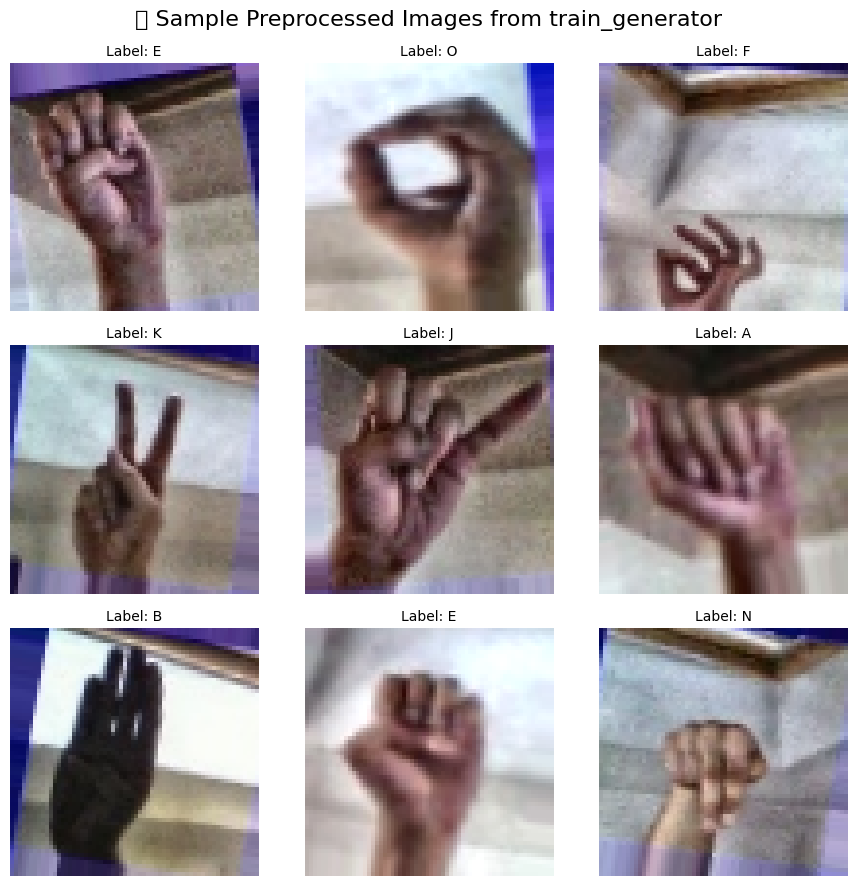

In [53]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_generator)

# Reverse label map
label_map = train_generator.class_indices
rev_map = {v: k for k, v in label_map.items()}
true_labels = [rev_map[np.argmax(l)] for l in labels]

# Clean grid plot
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
fig.suptitle("✨ Sample Preprocessed Images from train_generator", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {true_labels[i]}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


**Create Custom Test Set**

In [54]:
import os
import shutil
from glob import glob
from tqdm import tqdm

# Source = clean_dataset (prétraité avec CLAHE + MediaPipe)
SRC_DIR = '/content/clean_dataset'
DEST_DIR = '/content/clean_dataset_test'
IMAGES_PER_CLASS = 10  # Nombre d’images à déplacer pour chaque classe

# Crée le dossier de test vide (supprime s’il existe déjà)
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)
os.makedirs(DEST_DIR)

# Parcourir chaque classe (A, B, C...)
for class_name in tqdm(os.listdir(SRC_DIR)):
    class_src = os.path.join(SRC_DIR, class_name)
    class_dest = os.path.join(DEST_DIR, class_name)

    if not os.path.isdir(class_src):
        continue

    os.makedirs(class_dest, exist_ok=True)

    # Sélectionne les premières images pour le test set
    image_paths = sorted(glob(f'{class_src}/*.jpg'))[:IMAGES_PER_CLASS]

    for img_path in image_paths:
        filename = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(class_dest, filename))

print("Test set created in /content/clean_dataset_test")


100%|██████████| 29/29 [00:00<00:00, 615.45it/s]

Test set created in /content/clean_dataset_test


**Final Test Set Generator**

In [55]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/clean_dataset_test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 290 images belonging to 29 classes.


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
print("Packages imported ✔️")

Packages imported ✔️


**Building the CNN Model**

In [57]:
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(29, activation='softmax'))  # 29 ASL classes

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,637 (1.36 MB)

 Trainable params: 356,637 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

**Compiling the model**

In [63]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Adding early stopping**

In [64]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

**Train the Model Using Generators**

In [65]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/30
218/218 - 21s - 97ms/step - accuracy: 0.9524 - loss: 0.1463 - val_accuracy: 0.8989 - val_loss: 0.4207
Epoch 2/30
218/218 - 15s - 71ms/step - accuracy: 0.9583 - loss: 0.1342 - val_accuracy: 0.9098 - val_loss: 0.3511
Epoch 3/30
218/218 - 16s - 71ms/step - accuracy: 0.9568 - loss: 0.1336 - val_accuracy: 0.9230 - val_loss: 0.3235
Epoch 4/30
218/218 - 16s - 75ms/step - accuracy: 0.9609 - loss: 0.1279 - val_accuracy: 0.9034 - val_loss: 0.3372
Epoch 5/30
218/218 - 16s - 72ms/step - accuracy: 0.9566 - loss: 0.1342 - val_accuracy: 0.9132 - val_loss: 0.3427
